In [29]:
import scipy.io
import numpy as np
%matplotlib inline
from numpy import cos, sin, pi, absolute, arange
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, lfilter, firwin, freqz, impulse2, tf2zpk
import scipy.signal as signal
from numpy import random
from scipy.ndimage.interpolation import shift

import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import patches
from matplotlib.figure import Figure
from matplotlib import rcParams
import copy

In [3]:
def zplane(b,a,filename=None):
    """Plot the complex z-plane given a transfer function.
    """

    # get a figure/plot
    ax = plt.subplot(111)

    # create the unit circle
    uc = patches.Circle((0,0), radius=1, fill=False,
                        color='black', ls='dashed')
    ax.add_patch(uc)

    # The coefficients are less than 1, normalize the coeficients
    if np.max(b) > 1:
        kn = np.max(b)
        b = b/float(kn)
    else:
        kn = 1

    if np.max(a) > 1:
        kd = np.max(a)
        a = a/float(kd)
    else:
        kd = 1
        
    # Get the poles and zeros
    p = np.roots(a)
    z = np.roots(b)
    k = kn/float(kd)
    
    # Plot the zeros and set marker properties    
    t1 = plt.plot(z.real, z.imag, 'go', ms=10)
    plt.setp( t1, markersize=10.0, markeredgewidth=1.0,
              markeredgecolor='k', markerfacecolor='k')

    ax.set_title("z plane")

    # Plot the poles and set marker properties
    t2 = plt.plot(p.real, p.imag, 'rx', ms=10)
    plt.setp( t2, markersize=12.0, markeredgewidth=3.0,
              markeredgecolor='k', markerfacecolor='k')

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set the ticks
    r = 1.5; plt.axis('scaled'); plt.axis([-r, r, -r, r])
    ticks = [-1, -.5, .5, 1]; plt.xticks(ticks); plt.yticks(ticks)

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
    

    return z, p, k

In [63]:
def get_inputs(n):
    # utility function for fetching the EKG signal arrays and converting to numpy

    inputs = []
    for i in range(n):
        inputs.append(scipy.io.loadmat(f'EKG_{i+1}.mat')["ekg"][0])
    return inputs


def get_coefs(filename):
    # utility function for fetching RIR lowpass filter coefs from a file

    coefs = []
    for i in open(filename,'r').readlines():
        coefs.append(float(i))
    return coefs

def rir_lowpass_filter(x,rir_coefs):
    # rir lowpass filter implementation

    b = rir_coefs
    a = [1]
    y = lfilter(b,a,x)
    return y,a,b

def plot_filter_amplitude_phase_characteristics(w,h):
    # plot the magnitude and phase characteristics

    fig, axs = plt.subplots(2,1,figsize=(8,12),dpi=100)
    h_dB = 20 * np.log10 (abs(h))   
    h_Phase = np.unwrap(np.arctan2(np.imag(h),np.real(h)))

    axs[0].plot(w/np.max(w),h_dB,'k')

    axs[0].set_xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    axs[0].set_ylabel('Magnitude (db)')
    #axs[0].set_ylim(-150, 5)
    axs[0].grid()
    axs[0].set_title(r'Frequency response')
    axs[0].axhline(y=-3.0, color="black", linestyle="--")

    axs[1].plot(w/np.max(w), h_Phase, 'k')
    axs[1].set_xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    axs[1].set_ylabel('Phase (radians)')
    axs[1].grid()
    axs[1].axis('tight')
    axs[1].set_title(r'Phase response')
    plt.show()

def convert_to_frequency_domain(signal,fd):
    # return a frequency domain array of the signal

    nfft = len(signal)
    S = np.abs(np.fft.fft(signal) / nfft)
    S = 20 * np.log10(S/np.max(S))
    k = np.linspace(0,nfft,nfft)
    f = k*fd/nfft
    return f,S

def plot_impulse_characteristics(y):
    # plot the impulse response of a filter

    fig, axs = plt.subplots(1,1,figsize=(8,8),dpi=100)

    axs.stem(y,linefmt='-k',markerfmt='ko')

    axs.set_xlabel("n")
    axs.set_ylabel("h[n]")
    axs.set_title("Impulse Response")
    plt.show()
    

def plot_frequency(f,s,ax,fd):
    # plotting a signal's freq domain

    ax.set_xlabel('f, Hz')
    ax.set_ylabel('Sa, dB')
    #ax.set_xlim([0,1000])
    ax.set_xlim([0,fd/2])
    ax.set_ylim([-125,0])
    ax.set_title("frequency domain")
    ax.plot(f,s,'k')

def plot_signal(x,fd,title):
    # plotting a signal in time and freq domains

    fig, axs = plt.subplots(1,2,figsize=(18,8),dpi=100)
    axs[0].plot(x[fd:],'k')

    axs[0].set_ylabel("Amplitude")
    axs[0].set_xlabel("t, s")
    axs[0].set_title("time domain")
    fig.suptitle(title)

    f, s = convert_to_frequency_domain(x,fd)
    plot_frequency(f,s,axs[1],fd)
    plt.show()

def comb_filter(x,fd,delta_f,f0,k0):
    # comb NIR filter implementation

    L = 3
    n = fd/f0
    S = 20*np.log10(100)
    
    
    k = k0*(10**(-S/20))
    kr = k0*(10**(-L/20))
    
    

    beta = np.sqrt((kr**2-k0**2)/(k**2-kr**2)) * np.tan((n*pi*delta_f)/(2*fd))

    k1 = (k0+k*beta) / (1+beta)
    k2 = (k0-k*beta) / (1+beta)
    k3 = (1-beta) / (1+beta)


    b = np.concatenate(([k1] , np.zeros(int(n)-1) , [-k2]),axis=0)
    a = np.concatenate(([1] , np.zeros(int(n)-1) , [-k3]),axis=0)
    y = lfilter(b,a,x)

    return y,a,b

def impz(b,a=1):
    # generate impulse response of given filter coefs

    zeros = scipy.zeros(len(b))
    zeros[0] = 1
    return lfilter(b,a, zeros)

def analysis(b,a):
    # impulse, frequency, phase and zplane analysis of a given filter

    #1 impz
    h = impz(b,a)
    plot_impulse_characteristics(h)

    #2 freq
    w,h = freqz(b,a)
    plot_filter_amplitude_phase_characteristics(w,h)

    #3 poles
    zplane(b,a)

In [115]:
def lowpass_filter_own(x,fd,transition_width,attenuation,cutoff):
    #------------------------------------------------
    # Create a FIR filter and apply it to x.
    #------------------------------------------------

    # The Nyquist rate of the signal.
    nyq_rate = fd / 2.0

    # The desired width of the transition from pass to stop,
    # relative to the Nyquist rate.  We'll design the filter
    # with a 5 Hz transition width.
    width = 5.0/nyq_rate

    # The desired attenuation in the stop band, in dB.
    ripple_db = 60.0

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # The cutoff frequency of the filter.
    cutoff_hz = 10.0

    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

    # Use lfilter to filter x with the FIR filter.
    filtered_x = lfilter(taps, 1.0, x)

    return filtered_x

def highrate_fir(x,fd):
    factors = [5,5]
    delay_accumulation = 0

    transition_width = 5.0
    attenuation = 60.0
    cutoff = 10.0

    x_mem = copy.copy(x)
    
    #y = scipy.signal.decimate(x,q=factor,ftype="fir")

    # decimation

    # phase 1

    x = lowpass_filter_own(x,fd,transition_width,attenuation,cutoff)
    delay_accumulation += 0.5 * factors[0]

    downsampling_factor = int(len(x)/factors[0])
    fd = fd / factors[0]
    #print(f"downsampled to {fd} hz")
    
    x = signal.resample(x, downsampling_factor)

    # phase 2

    x = lowpass_filter_own(x,fd,transition_width,attenuation,cutoff)
    delay_accumulation += 0.5 * factors[1]

    downsampling_factor = int(len(x)/factors[1])
    fd = fd / factors[1]
    
    x = signal.resample(x, downsampling_factor)
    #print(f"downsampled to {fd} hz")


    # lowpass filter (bazines linijos dreifas)

    rir_coefs = get_coefs("koefs.txt")
    x,a,b = rir_lowpass_filter(x,rir_coefs)

    # interpolation

    # phase 1
    upsample_factor = int(len(x)*factors[0])
    fd = fd * factors[0]
    x = signal.resample(x, upsample_factor)
    #print(f"upsampled to {fd} hz")
    x = lowpass_filter_own(x,fd,transition_width,attenuation,cutoff)
    delay_accumulation += 0.5 * factors[0]

    # phase 2
    upsample_factor = int(len(x)*factors[1])
    fd = fd * factors[1]
    x = signal.resample(x, upsample_factor)
    #print(f"upsampled to {fd} hz")
    x = lowpass_filter_own(x,fd,transition_width,attenuation,cutoff)
    delay_accumulation += 0.5 * factors[1]

    # delay
    x_mem = shift(x_mem, delay_accumulation, cval=0.0)

    # combine
    y = x_mem - x

    # add amplitude
    #y = y*10


    return y

In [116]:
def part_1(x,fd):

    #1 rir filter
    rir_coefs = get_coefs("koefs.txt")
    y,a,b = rir_lowpass_filter(x,rir_coefs)

    plot_signal(x,fd, "EKG signal before filtering")
    plot_signal(y,fd, "EKG signal after RIR filtering")

    analysis(b,a)

    return y


def part_2(x,fd):

    #1 comb filter
    delta_f = 3
    f0 = 50
    k0 = 1
    y,a,b = comb_filter(x,fd,delta_f,f0,k0)

    plot_signal(x,fd, "EKG signal before comb filtering")
    plot_signal(y,fd, "EKG signal after comb NIR filtering")

    analysis(b,a)

    return y

def part_3(x,fd):

    #1 lowpass2
    y = highrate_fir(x,fd)

    plot_signal(x,fd, "EKG signal before final filtering")
    plot_signal(y,fd, "EKG signal after final filtering")

    #analysis(b,a)

    return y

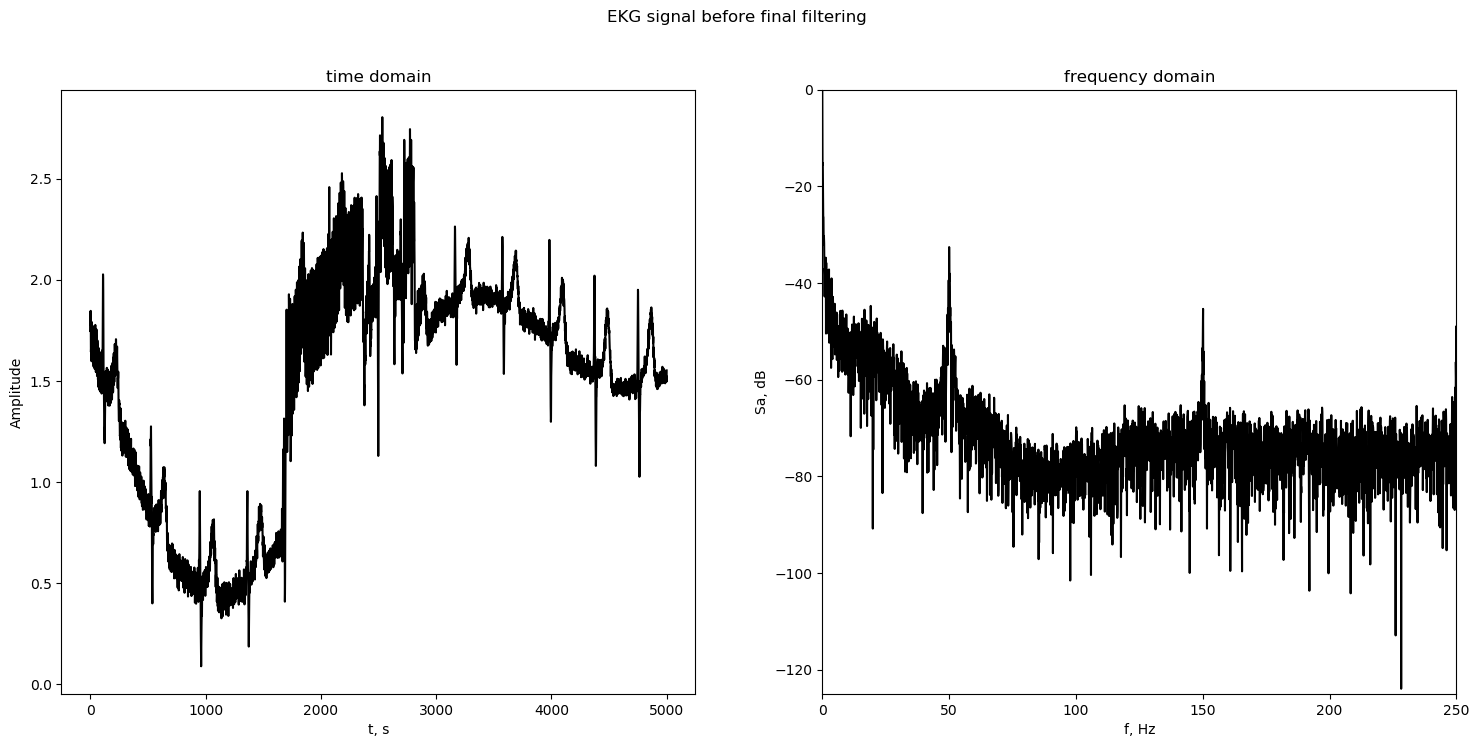

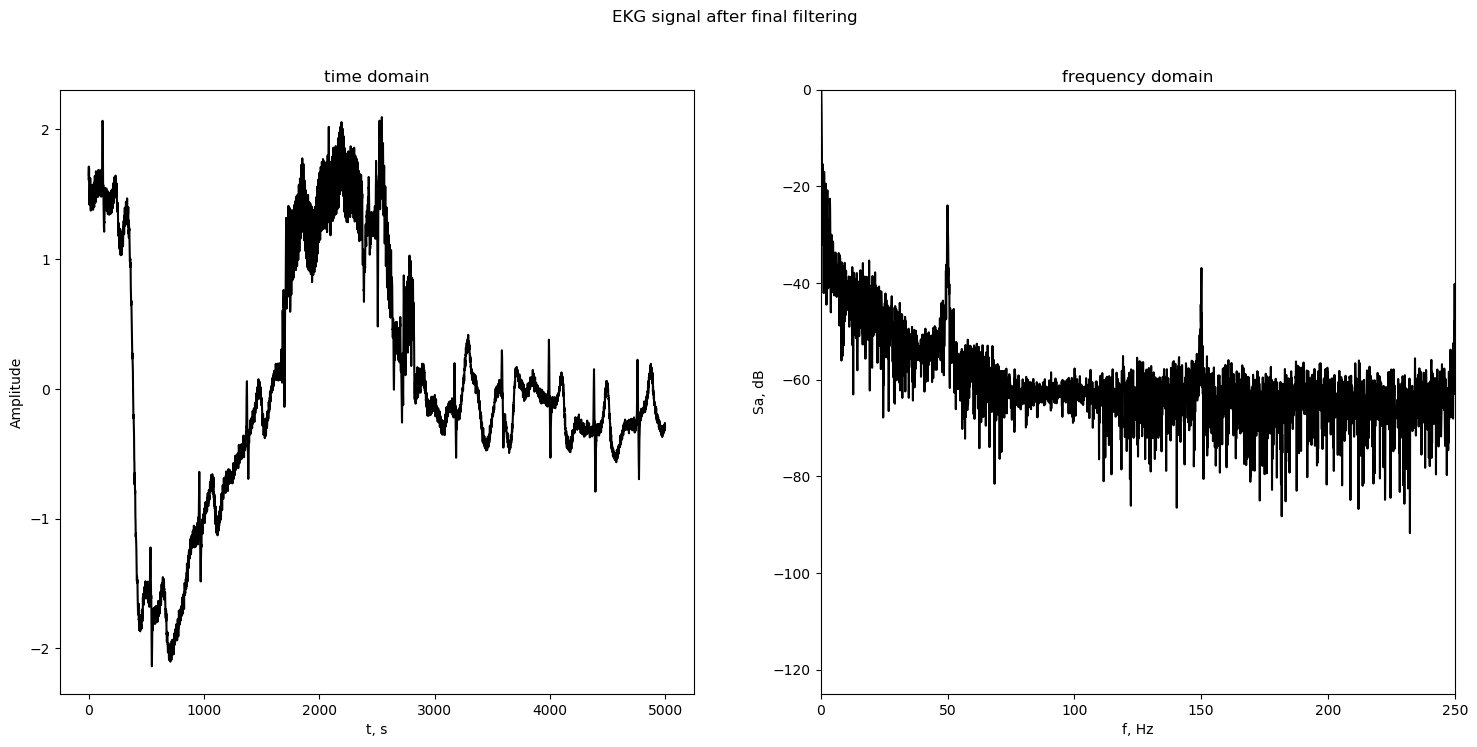

In [118]:
input_count = 10
inputs = get_inputs(input_count)
x = inputs[4]
fd = 500
#y0 = part_1(x,fd)
#y1 = part_2(y0,fd)
#y2 = part_3(y1,fd)

y = part_3(x,fd)

In [ ]:
#